In [1]:
#       Copyright 2021
#       Abhirup Ghosh <abhirup.ghosh.184098@gmail.com>,
#
#       This program is free software; you can redistribute it and/or modify
#       it under the terms of the GNU General Public License as published by
#       the Free Software Foundation; either version 2 of the License, or
#       (at your option) any later version.
#
#       This program is distributed in the hope that it will be useful,
#       but WITHOUT ANY WARRANTY; without even the implied warranty of
#       MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#       GNU General Public License for more details.
#
#       You should have received a copy of the GNU General Public License
#       along with this program; if not, write to the Free Software
#       Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston,
#       MA 02110-1301, USA.

# Environment

#### Hypatia
* virtual env: source envs/pSEOBNRv4HM_tgr_injections/bin/activate
* lalsuite: source $VIRTUAL_ENV/opt/lalsuite_pSEOBNRv4HM_tgr_injection/etc/lal*.sh

#### Laptop
* virtual env: source envs/pSEOBNRv4HM_tgr_injection/bin/activate
* lalsuite: source $VIRTUAL_ENV/opt/lalsuite_pSEOBNRv4HM_tgr_injection_20210117_328f49d2/etc/lalsuiterc 

In [2]:
#%matplotlib notebook
import os

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator,AutoMinorLocator
from scipy.ndimage import gaussian_filter
from scipy.interpolate import CubicSpline
from scipy.stats import gaussian_kde
import pandas as pd
import corner
import json
import lalsimulation

import lal
import lalsimulation as lalsim

import sys
sys.path.append('../papers/intro_paper/code')
sys.path.append('../scripts')

import compute_sigmalm0_SimIMREOBGenerateQNMFreqV2 as calcqnm
import scipy
import scipy.signal as ss
from scipy import interpolate
import scipy.ndimage.filters as filter
from optparse import OptionParser
import glob
import h5py
import seaborn as sns

from bounded_1d_kde import Bounded_1d_kde
from bounded_2d_kde import Bounded_2d_kde


plt.style.use("../papers/intro_paper/MATPLOTLIB_RCPARAMS.sty") 

In [3]:
plt.style.use("../papers/intro_paper/MATPLOTLIB_RCPARAMS.sty") 

### Functions

In [4]:
# Module for confidence calculations
class confidence(object):
    def __init__(self, counts):
        # Sort in descending order in frequency
        self.counts_sorted = np.sort(counts.flatten())[::-1]
        # Get a normalized cumulative distribution from the mode
        self.norm_cumsum_counts_sorted = np.cumsum(self.counts_sorted) / np.sum(counts)
        # Set interpolations between heights, bins and levels
        self._set_interp()
    def _set_interp(self):
        self._length = len(self.counts_sorted)
        # height from index
        self._height_from_idx = interpolate.interp1d(np.arange(self._length), self.counts_sorted, bounds_error=False, fill_value=0.)
        # index from height
        self._idx_from_height = interpolate.interp1d(self.counts_sorted[::-1], np.arange(self._length)[::-1], bounds_error=False, fill_value=self._length)
        # level from index
        self._level_from_idx = interpolate.interp1d(np.arange(self._length), self.norm_cumsum_counts_sorted, bounds_error=False, fill_value=1.)
        # index from level
        self._idx_from_level = interpolate.interp1d(self.norm_cumsum_counts_sorted, np.arange(self._length), bounds_error=False, fill_value=self._length)
    def level_from_height(self, height):
        return self._level_from_idx(self._idx_from_height(height))
    def height_from_level(self, level):
        return self._height_from_idx(self._idx_from_level(level))

# gaussian filter of histogram
def gf(P):
    return filter.gaussian_filter(P, sigma=2.0)

# construct effective quantities from PE samples
def eff_quant(m1, m2, a1z, a2z, domega, dtau, lm):
    omega_GR, tau_GR = calcqnm.get_sigmalm0SI_GR(m1, m2, a1z, a2z, lm)
    freq_GR = omega_GR/(2.*np.pi)

    omega_modGR, tau_modGR = calcqnm.get_sigmalm0SI_modGR(omega_GR, tau_GR, domega, dtau)
    freq_modGR = omega_modGR/(2.*np.pi)
    
    return freq_GR, tau_GR, freq_modGR, tau_modGR

# using fitting formulas from https://arxiv.org/pdf/gr-qc/0512160.pdf
# to get final mass and final spin from omega220 and tau220.
# See eqs.2.1, E1 and E2, and table VIII for fitting coefficients

def Mjfinal220(omega220,tau220):

    jf=1-pow((omega220*tau220/2.-0.7)/(1.4187),-1/0.4990)
    Mf=((1.5251 - 1.1568*pow((1 - jf),0.1292))/omega220)*(pow(lal.C_SI,3)/lal.G_SI/lal.MSUN_SI)
    
    idx, = np.where(jf < 0.)
    jf[idx] = 0.

    return Mf,jf

def Mjfinal330(omega330,tau330):

    jf=1-pow((omega330*tau330/2.-0.9)/(2.3430),-1/0.4810)
    Mf=((1.8956 - 1.3043*pow((1 - jf), 0.1818))/omega330)*(pow(lal.C_SI,3)/lal.G_SI/lal.MSUN_SI)

    idx, = np.where(jf < 0.)
    jf[idx] = 0.
    
    return Mf,jf

# 2D histogram
def P_xy_2dhist(x, y, N_bins):
    x_bins = np.linspace(min(x), max(x), N_bins)
    y_bins = np.linspace(min(y), max(y), N_bins)

    dx = np.mean(np.diff(x_bins))
    dy = np.mean(np.diff(y_bins))

    x_intp = (x_bins[:-1] + x_bins[1:])/2.
    y_intp = (y_bins[:-1] + y_bins[1:])/2.
    
    P_xy, x_bins, y_bins = np.histogram2d(x, y, bins=(x_bins, y_bins), normed=True)
    P_xy = P_xy.T
    
    conf = confidence(P_xy)
    s1 = conf.height_from_level(0.5)
    s2 = conf.height_from_level(0.9)
    
    P_x = np.sum(P_xy, axis=0) * dy
    P_y = np.sum(P_xy, axis=1) * dx
    
    return P_xy, P_x, P_y, x_intp, y_intp, s1, s2

def add_extra_quantities_to_samples(data):

    data = pd.DataFrame(data)
    
    # read out the specific columns: m1,m2,a1z,a2z
    m1, m2, a1z, a2z = data["m1"], data["m2"], data["a1z"], data["a2z"]
    
    # check if columns domega220,dtau220 are present in the data
    # read in if yes, otherwise make an array of zeros of same length as m1
    if ('domega220' in data.dtypes.keys()) == True:
        domega220, dtau220 = data["domega220"], data["dtau220"]
    else:
        domega220, dtau220 = np.zeros(len(m1)), np.zeros(len(m1)) 
        
    if ('domega330' in data.dtypes.keys()) == True:
        domega330, dtau330 = data["domega330"], data["dtau330"]
    else:
        domega330, dtau330 = np.zeros(len(m1)), np.zeros(len(m1)) 

    # construct the frequencies and damping times
    freq_GR_220, tau_GR_220, freq_modGR_220, tau_modGR_220 = eff_quant(m1, m2, a1z, a2z, domega220, dtau220, [2,2])
    freq_GR_330, tau_GR_330, freq_modGR_330, tau_modGR_330 = eff_quant(m1, m2, a1z, a2z, domega330, dtau330, [3,3])

    # construct the final mass and spin
    Mf220, af220 = Mjfinal220(2.*np.pi*freq_modGR_220,tau_modGR_220)
    Mf330, af330 = Mjfinal330(2.*np.pi*freq_modGR_330,tau_modGR_330)

    # converty damping time samples from second to milli-second
    tau_GR_220 *= 1000.
    tau_modGR_220 *= 1000.
    tau_GR_330 *= 1000.
    tau_modGR_330 *= 1000.

    data['fgr220'],data['taugr220'] = freq_GR_220, tau_GR_220
    data['fngr220'],data['taungr220'] = freq_modGR_220, tau_modGR_220
    data['Mfngr220'],data['afngr220'] = Mf220, af220
    data['fgr330'],data['taugr330'] = freq_GR_330, tau_GR_330
    data['fngr330'],data['taungr330'] = freq_modGR_330, tau_modGR_330
    data['Mfngr330'],data['afngr330'] = Mf330, af330
    
    return data


def make_nice_plot(data_dict, runs, labels, colors, file_name, 
                   params=['domega220','dtau220'], truths=[0., 0.], \
                   axeslabels=['domega220', 'dtau220']):
    
    import matplotlib.gridspec as gridspec
    show_hist=False # For debugging -- set this to true to show the histogram to check the kde isn't lying

    # parameters to plot
    params=params
    
    # short hand for parameters used later
    p1=params[0]
    p2=params[1]
    
    # injected value
    truth={p1:truths[0],p2:truths[1]}
    # colors and labels for two injections
    colors=colors
    labels=labels
    
    # create figure and axes
    fig,axes=plt.subplots(2,2,facecolor='white')
    gs=gridspec.GridSpec(2,2,width_ratios=[4,1],height_ratios=[1,4],wspace=0,hspace=0)
    p1_axis=plt.subplot(gs[0])
    p2_axis=plt.subplot(gs[3])
    p1p2_axis=plt.subplot(gs[2])
    
    xmin_p1 = 1e16
    xmax_p1 = -1e16
    xmin_p2 = 1e16
    xmax_p2 = -1e16
    ymax_p1 = 0.1
    ymax_p2 = 0.1
    
    p1_bins=np.linspace(xmin_p1,xmax_p1,1000)
    p2_bins=np.linspace(xmin_p2,xmax_p2,1000)
    
    # Loop over the data1 and data2 samples
    for color,label,run in zip(colors,labels,runs):
        
        data = data_dict[run]
        data = add_extra_quantities_to_samples(data)
        
        if xmin_p1 >= min(data[p1]):
            xmin_p1 = min(data[p1])
        if xmax_p1 <= max(data[p1]):
            xmax_p1 = max(data[p1])
        if xmin_p2 >= min(data[p2]):   
            xmin_p2 = min(data[p2])
        if xmax_p2 <= max(data[p2]):
            xmax_p2 = max(data[p2])
        xlims={p1:(xmin_p1,xmax_p1), p2:(xmin_p2,xmax_p2)}
        
        p1_bins=np.linspace(xmin_p1,xmax_p1,1000)
        p2_bins=np.linspace(xmin_p2,xmax_p2,1000)
        
        nsamples=len(data['mc'])

        # p1 1d-histogram
        x=params[0]
        ax=p1_axis
        if show_hist:
            _=ax.hist(data[x],density=True,bins=100,alpha=0.2,color='black')
        kde=Bounded_1d_kde(data[x],xlow=min(data[x]))
        #ax.fill_between(p1_bins,0,kde(p1_bins),color=color,alpha=0.5)
        ax.plot(p1_bins,kde(p1_bins),color=color,linewidth=2)
        ax.axvline(np.percentile(data[x],5),linestyle='--',linewidth=2,color=color)
        ax.axvline(np.percentile(data[x],95),linestyle='--',linewidth=2,color=color)  
        ax.axvline(truth[x],color='black',linestyle='dashed',alpha=0.5) 
        
        if max(kde(p1_bins)) >= ymax_p1:
            ymax_p1 = max(kde(p1_bins))
        
        ax.set_ylim([0, ymax_p1])
        ax.set_xlim(xlims[x])
        ax.set_yticklabels([])
        ax.tick_params(bottom=True,left=False,right=False,top=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        # p2 1d-histogram
        y=params[1]
        ax=p2_axis
        if show_hist:
            _=ax.hist(data[y],density=True,bins=100,alpha=0.2,color='black',orientation='horizontal')
        kde=Bounded_1d_kde(data[y],xhigh=max(data[y]))
        #ax.fill_betweenx(p2_bins,0,kde(p2_bins),color=color,alpha=0.5)
        ax.plot(kde(p2_bins),p2_bins,color=color,linewidth=2)
        ax.axhline(np.percentile(data[y],5),linestyle='--',linewidth=2,color=color)
        ax.axhline(np.percentile(data[y],95),linestyle='--',linewidth=2,color=color)  
        ax.axhline(truth[y],color='black',linestyle='dashed',alpha=0.5) 
                          
        if max(kde(p2_bins)) >= ymax_p2:
            ymax_p2 = max(kde(p2_bins))                         
                          
        ax.set_xlim([0, ymax_p2])
        ax.set_ylim(xlims[y])
        ax.set_xticklabels([])
        ax.tick_params(bottom=False,left=False,right=False,top=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

        # p1-p2 2d histogram
        corner.hist2d(np.array(data[p1]),np.array(data[p2]),color=color,
                      ax=p1p2_axis,
                     levels=[0.9],plot_density=True,bins=100,smooth=2.)
        p1p2_axis.plot(-1,-1,linewidth=2,alpha=1,color=color,label=label) # fake points to make legend
        p1p2_axis.set_xlim(xlims[p1])
        p1p2_axis.set_ylim(xlims[p2])
        p1p2_axis.axvline(truth[p1],color='black',linestyle='dashed',alpha=0.5)
        p1p2_axis.axhline(truth[p2],color='black',linestyle='dashed',alpha=0.5)
        p1p2_axis.set_xlabel(axeslabels[0])
        p1p2_axis.set_ylabel(axeslabels[1])
        p1p2_axis.scatter(truth[p1],truth[p2],color='black',marker='s',linewidth=5,zorder=100)

    
    # put on ticks
    ax=p1p2_axis
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis="x",which='minor',length=5,bottom=True,left=True,top=True,right=True,direction='in')
    ax.tick_params(axis="y",which='minor',length=5,bottom=True,left=True,top=True,right=True,direction='in')
    ax.tick_params(axis="x",which='major',length=10,labelsize=25,bottom=True,left=True,top=True,right=True,direction='in')
    ax.tick_params(axis="y",which='major',length=10,labelsize=25,bottom=True,left=True,top=True,right=True,direction='in')

    # turn off the border for the 1d histograms
    ax.legend(loc='best',frameon=False) 
    
    # save the plot
    fig.subplots_adjust(wspace=0)
    fig.subplots_adjust(hspace=0)
    plt.tight_layout() # avoids overlapping labels
    plt.savefig(file_name,bbox_inches='tight') 
    return None

### Colour-blind color list

#377eb8
#ff7f00
#4daf4a
#f781bf
#a65628
#984ea3
#999999
#e41a1c
#dede00


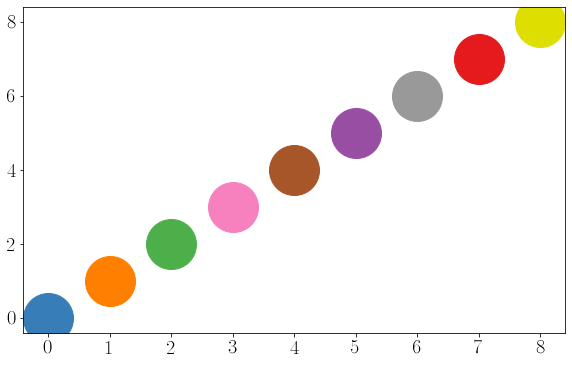

In [5]:
CB_color_list = ['#377eb8', '#ff7f00', '#4daf4a', \
                  '#f781bf', '#a65628', '#984ea3', \
                  '#999999', '#e41a1c', '#dede00']

fig = plt.figure()
ax = fig.add_subplot(111)

for idx in range(len(CB_color_list)):
    print(CB_color_list[idx])
    ax.plot(idx, idx, marker='o', ms=50, color=CB_color_list[idx])
plt.show()    

# Data: PA/nonPA

In [54]:
# data

data_dict = {}

for run in ['220', '220_deyan_PA']:
        
        data_dict[run] = np.genfromtxt(f'../runs/O1O2/GW150914/{run}/cbcBayes/posterior_samples.dat', dtype=None, names=True)

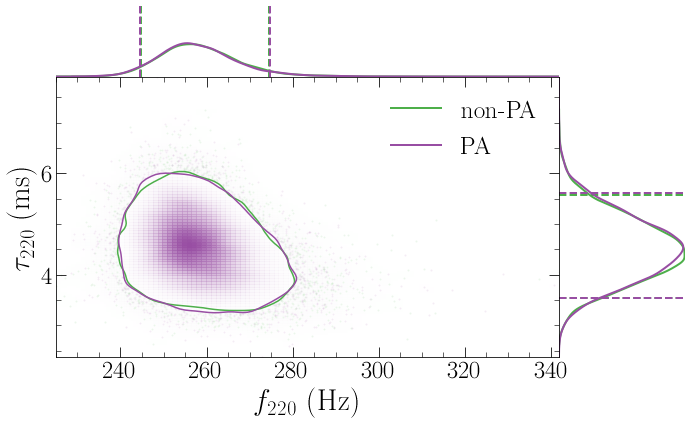

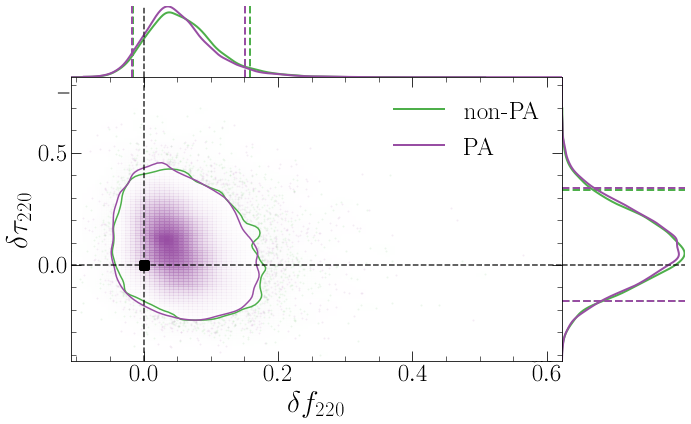

In [55]:
runs=['220', '220_deyan_PA']
labels=['non-PA', 'PA']

color_non_pa = CB_color_list[2]
color_pa = CB_color_list[5]

colors = [color_non_pa, color_pa]

make_nice_plot(data_dict, runs=runs, labels=labels, colors=colors, \
                   file_name='../papers/intro_paper/PA_paper_section/GW150914_actual_PA_nonPA_fngrtaungr.png', \
                   params=['fngr220','taungr220'], truths=[0., 0.], \
                   axeslabels=['$f _{220}$ (Hz)','$\\tau _{220}$ (ms)'])

make_nice_plot(data_dict, runs=runs, labels=labels, colors=colors, \
                   file_name='../papers/intro_paper/PA_paper_section/GW150914_actual_PA_nonPA_domega220dtau220.png', \
                   params=['domega220','dtau220'], truths=[0., 0.], \
                   axeslabels=['$\delta f_{220}$','$\delta\\tau _{220}$'])

plt.show()

## Benchmarking

slope(PA)/slope(non-pa): 8.36 (Roughly the rate at which the PA run accumulates samples faster than the non-PA run)


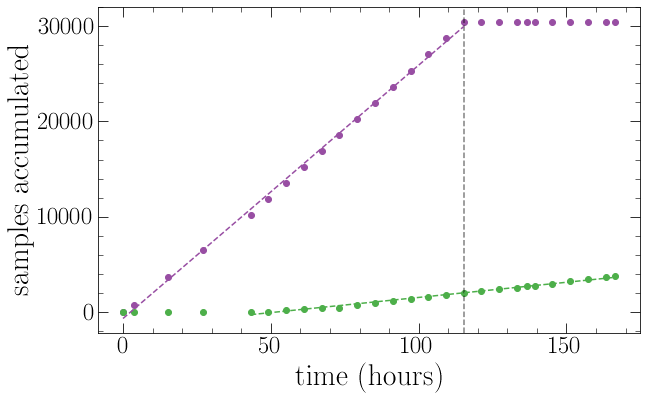

In [58]:
from scipy.optimize import curve_fit

def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B


time, data_pa, data_non_pa = np.genfromtxt("../data/benchmarking_gw150914.dat", unpack=True)
t0 = time[0]

pa_end_time = 1614596827

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot((time - t0)/ 60. / 60., data_pa, color=color_pa, marker='o', ls='')
plt.plot((time - t0)/ 60./ 60., data_non_pa, color=color_non_pa, marker='o', ls='')
plt.axvline(x = (pa_end_time - t0)/60./60., ls='dashed', color='k', alpha=0.5)
plt.xlabel("time (hours)")
plt.ylabel("samples accumulated")


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis="x",which='minor',length=5,bottom=True,left=True,top=True,right=True,direction='in')
ax.tick_params(axis="y",which='minor',length=5,bottom=True,left=True,top=True,right=True,direction='in')
ax.tick_params(axis="x",which='major',length=10,labelsize=25,bottom=True,left=True,top=True,right=True,direction='in')
ax.tick_params(axis="y",which='major',length=10,labelsize=25,bottom=True,left=True,top=True,right=True,direction='in')

time_non_pa, data_non_pa = time[4:], data_non_pa[4:]
time_pa, data_pa = time[:-10], data_pa[:-10]

popt1, pcov1 = curve_fit(f, time_pa-t0, data_pa) # your data x, y to fit
popt2, pcov2 = curve_fit(f, time_non_pa-t0, data_non_pa) # your data x, y to fit

plt.plot( (time_pa-t0)/ 60. / 60., f(time_pa-t0, popt1[0], popt1[1]), ls='dashed', color=color_pa)
plt.plot( (time_non_pa-t0)/ 60. / 60., f(time_non_pa-t0, popt2[0], popt2[1]), ls='dashed',color=color_non_pa)

print(f"slope(PA)/slope(non-pa): {popt1[0]/popt2[0]:.2f} \
(Roughly the rate at which the PA run accumulates samples faster than the non-PA run)")


plt.savefig('../papers/intro_paper/PA_paper_section/GW150914_actual_PA_nonPA_benchmarking.png')
plt.show()

[ 7.39101335e-02 -1.19305100e+08]
[ 8.39446689e-03 -1.35516660e+07]


[    0.   670.  3643.  6488. 10149. 11834. 13494. 15190. 16889. 18576.
 20271. 21957. 23656. 25348. 27045. 28744.]
